In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/CCPD2019-dl1.zip /content
!unzip -qq /content/CCPD2019-dl1.zip 
!cp -r /content/CCPD2019-dl1/test /content
!cp -r /content/CCPD2019-dl1/train /content

In [77]:
!pip install --quiet torchmetrics

In [69]:
import os
import sys
import random
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.utils.data import random_split
from tqdm.notebook import tqdm, tnrange
import torchmetrics
sys.path.insert(0, '../')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
# https://github.com/Deepayan137/Adapting-OCR/blob/master/src/utils/utils.py

class OCRLabelConverter(object):

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet
        self.dict = {}
        for i, char in enumerate(alphabet):
            self.dict[char] = i + 1
        self.dict[''] = 0

    def encode(self, text):
        length, result  = [], []

        for item in text:
            length.append(len(item))
            for char in item:
                index = self.dict[char] if char in self.dict else 0
                result.append(index)
        return (torch.IntTensor(result), torch.IntTensor(length))


    def decode(self, t, length, raw=False):

        if length.numel() == 1:
            length = length[0]
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)

        else: # batch mode
            texts, index = [], 0
            index = 0

            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts

In [84]:
class OCRDataset(Dataset):
    def __init__(self, path, imgdir, imgH, imgW):
        super(OCRDataset, self).__init__()
        self.path = os.path.join(path, imgdir)
        self.images = os.listdir(self.path)
        self.alphabet = ''.join(set(char for img in self.images 
                            for char in img.split('-')[1].replace('.jpg',''))) + '-'
        self.nSamples = len(self.images)
        self.imagepaths = list(map(lambda x: os.path.join(self.path, x), self.images))
        transform_list =  [transforms.Grayscale(1),
                            transforms.ToTensor(), 
                            transforms.Resize((imgH, imgW), antialias=True),
                            transforms.Normalize((0.5,), (0.5,))]
        
        self.transform = transforms.Compose(transform_list)

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        imagepath = self.imagepaths[index]
        imagefile = os.path.basename(imagepath)
        img = Image.open(imagepath)
        img = self.transform(img) if self.transform is not None else img
        item = {'img': img, 
                'label': imagefile.split('-')[1].replace('.jpg','')}
        return item 

In [17]:
# https://github.com/meijieru/crnn.pytorch/blob/master/models/crnn.py

class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, nHidden, imgH, nClasses, nChannels, leakyRelu=False):
        super(CRNN, self).__init__()

        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 4]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nChannels if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2)) 
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1))) 
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1))) 
        convRelu(6, True) 
        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(nHidden * 2, nHidden, nHidden),
            BidirectionalLSTM(nHidden, nHidden, nClasses))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

In [26]:
BATCH_SIZE = 32
LR = 1e-4
IMGH = 64
IMGW = 160 # round(ImgH * 2.5)
NHIDDEN = 256 #Hidden dim of RNN's
NCHANNELS = 1 # Img channels count
EPOCHS = 4
LOG_PERIOD = 100
PATH = '/content'
SAVEPATH = PATH


data = OCRDataset(PATH, 'train', IMGH, IMGW)
train_split = int(0.8*len(data))
val_split = len(data) - train_split
train_data, val_data = random_split(data, (train_split, val_split))

NCLASSES = len(data.alphabet) # Length of alphabet

model = CRNN(NHIDDEN, IMGH, NCLASSES, NCHANNELS)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_fn = torch.nn.CTCLoss(reduction='mean')

converter = OCRLabelConverter(data.alphabet)

train_dataloader = torch.utils.data.DataLoader(train_data,
                batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_data,
                batch_size=BATCH_SIZE)

In [141]:
min_val_loss = float('inf')

for epoch in tnrange(EPOCHS):
    val_loss, train_loss = [], []

    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, desc='Training')):
        input_, targets = batch['img'], batch['label']
        targets, lengths = converter.encode(targets)
        logits = model(input_.to(device))
        logits = logits.transpose(1, 0)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = loss_fn(logits, targets, pred_sizes, lengths)
        train_loss.append(loss.item())

        if idx % LOG_PERIOD == 0:
            print(f'Batch {idx}: train loss - {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}: avg train loss - {round(sum(train_loss) / len(train_loss),4)}')

    model.eval()
    for batch in tqdm(val_dataloader, desc='Validating'):
        input_, targets = batch['img'], batch['label']
        targets, lengths = converter.encode(targets)
        logits = model(input_.to(device))
        logits = logits.transpose(1, 0)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = loss_fn(logits, targets, pred_sizes, lengths)
        val_loss.append(loss.item())

    avg_val_loss = sum(val_loss) / len(val_loss)
    if avg_val_loss < min_val_loss:
        min_val_loss = loss.item()
        torch.save(model.state_dict(), os.path.join(SAVEPATH, 'best.ckpt'))
        print('*'*30,'\nVal loss decreased. New model saved')

    print(f'Epoch {epoch}: avg val loss - {round(sum(val_loss) / len(val_loss),4)}')

## Evaluation and testing

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.font_manager import fontManager
from torchvision.utils import make_grid

# Install Chinese fonts
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

In [132]:
def get_accuracy(model, test_loader, batch_size, converter, columns, rows, figsize, negative = False, 
                 print_stats = False, cer = torchmetrics.functional.char_error_rate):
    model.eval()
    labels, predictions, images = [], [], []
    for iteration, batch in enumerate(tqdm(test_loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for _ in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data)
        predictions.extend(sim_preds)

    if print_stats:
        accuracy = round(sum([predictions[i] == labels[i] for i in range(len(labels))]) / len(labels), 4)
        CER = round(cer(predictions, labels).item(), 4)
        print(f'{accuracy = }\n{CER = }')

    worst_preds_idxs = [i for i in range(len(labels)) if predictions[i] != labels[i]]
        
    fig=plt.figure(figsize=figsize)
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(worst_preds_idxs) if negative else np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]].cpu()
        img = (img - img.min())/(img.max() - img.min())
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title('pr: ' + predictions[indices[i]]+ '\n' + 
                  'gt: ' + labels[indices[i]])
        plt.axis('off')
        plt.imshow(img, cmap='gray')
    plt.show()

In [139]:
def result_analysis(negative = False, columns = 6, rows = 7, figsize = (10, 10), print_stats=False):
    test_data = OCRDataset(PATH, 'test', IMGH, IMGW)
    test_dataloader = torch.utils.data.DataLoader(test_data,
                    batch_size=BATCH_SIZE)

    resume_file = os.path.join(SAVEPATH, 'best.ckpt')

    if os.path.isfile(resume_file):
        print(str(not negative) + ' CLASSIFIED IMAGES')
        model.load_state_dict(torch.load(resume_file))
        get_accuracy(model, test_dataloader, BATCH_SIZE, converter,
                     columns, rows, figsize, negative=negative, print_stats=print_stats)
    else:
        print(f"=> no checkpoint found at '{resume_file}'")
        print('Exiting')

False CLASSIFIED IMAGES


  0%|          | 0/313 [00:00<?, ?it/s]

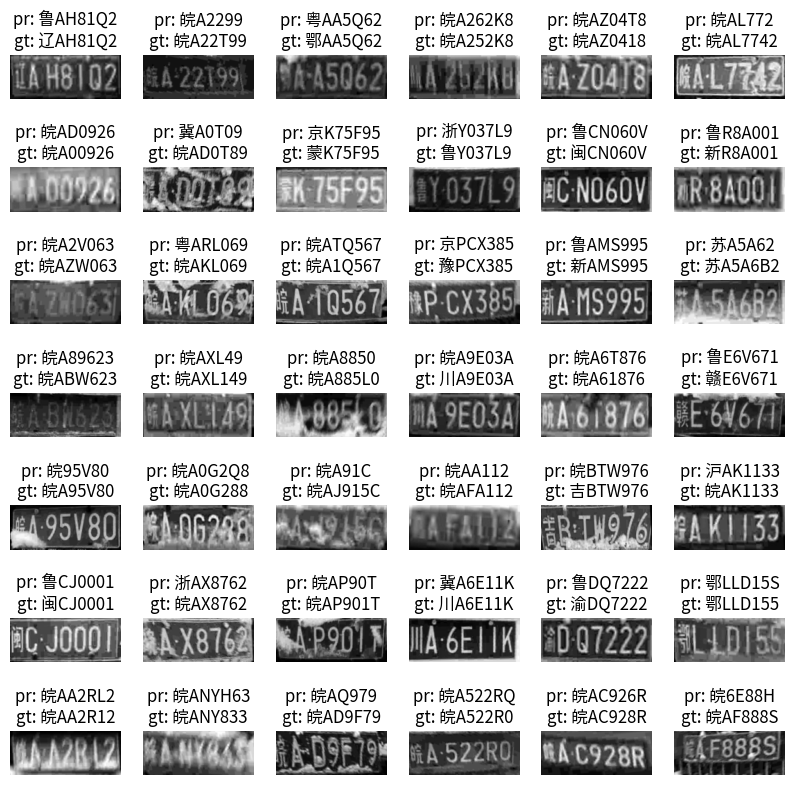

In [134]:
result_analysis(1)

False CLASSIFIED IMAGES


  0%|          | 0/313 [00:00<?, ?it/s]

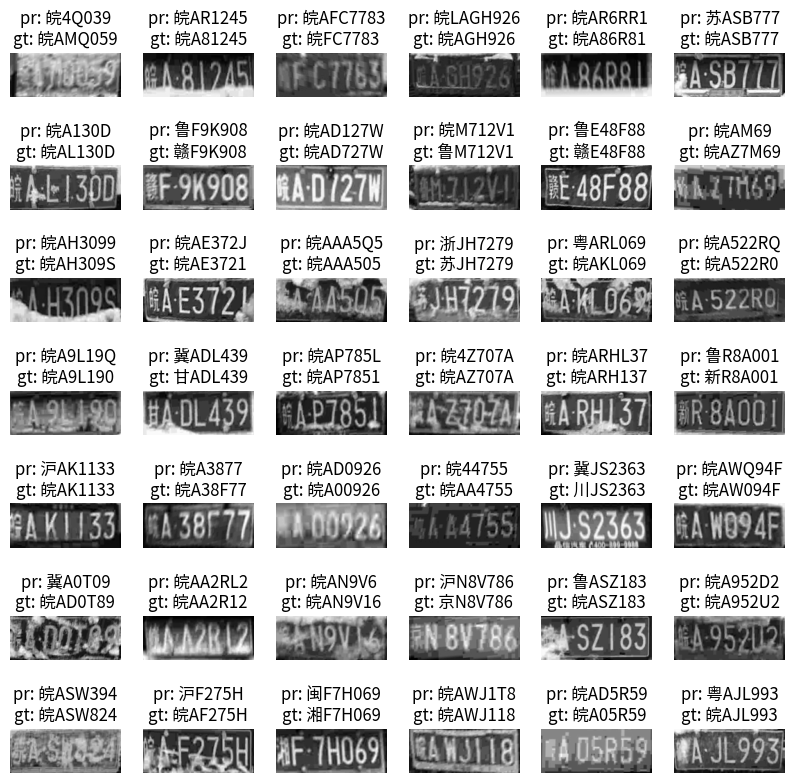

In [135]:
result_analysis(1)

True CLASSIFIED IMAGES


  0%|          | 0/313 [00:00<?, ?it/s]

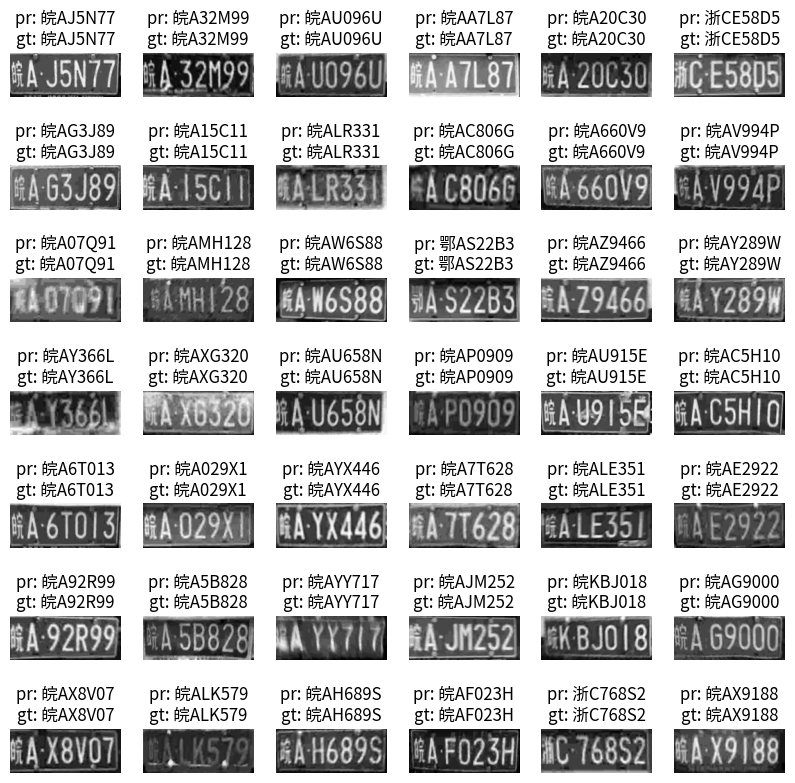

In [137]:
result_analysis()

True CLASSIFIED IMAGES


  0%|          | 0/313 [00:00<?, ?it/s]

accuracy = 0.9704
CER = 0.005


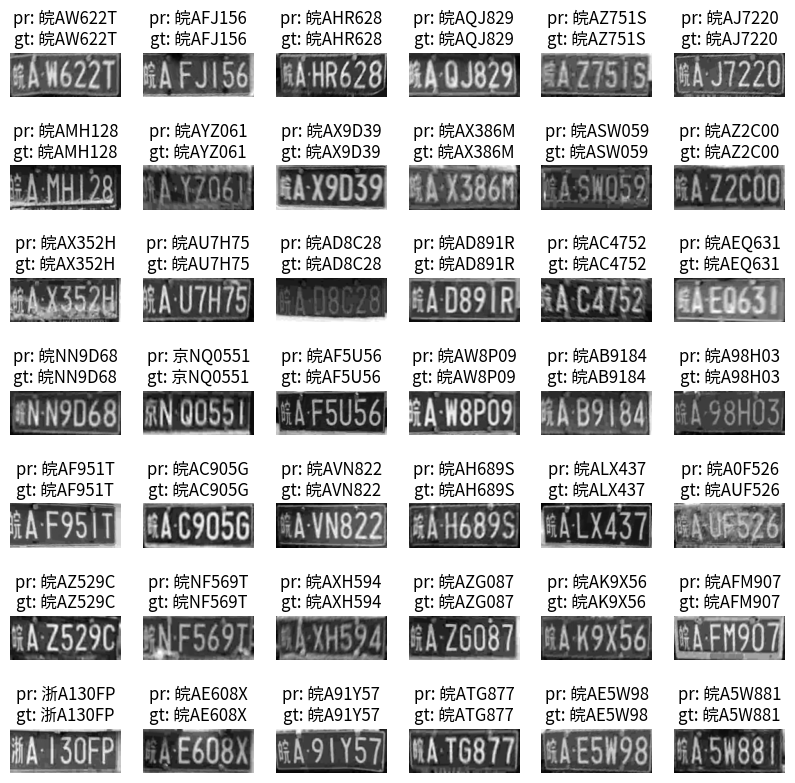

In [140]:
result_analysis(print_stats=True)

When model failes at most:


* When Chinese symbol is very difficult and/or cuts off from image
* When image is low-quality(lowres, blur, low contrast)
* When photo is smeared by moving of car(or camera maybe)
* When artefacts exist on a photo(white or black clouds like on an images above)
-------------------
* When "1" or "l", "W" or "V", "F" or "E", "Q" or "O", "D" and "0" and similar chars in a sequence and one of the issues above exists


TODO:
* Try augmentations and increase sharpness(to make contours if image more recognizable), rotations, contrast etc.
* Try to train model on rgb images(not grayscale like i made)
* Try different image size(some chinese symbols cuts off the image 'cause this)




Final Metrics: 
Accuracy - ```0.9704```, CER - ```0.005```